In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('raw_debt_risk_dataset.csv')

In [3]:
print(df.head())

   Age  Gender           Race Education Level    Industry  \
0   28    Male  Black African      Bachelor's          IT   
1   25    Male  Black African     High School          IT   
2   34  Female  Black African      Bachelor's   Education   
3   32    Male  Black African         Diploma   Education   
4   29  Female  Black African     High School  Healthcare   

   Weekly Hours Worked  Salary (ZAR)  Rent (ZAR)  Transport (ZAR)  \
0                   40         33849    13486.41          3876.51   
1                   45         14784     4848.72          1950.67   
2                   45         22210     6777.67          2278.98   
3                   40         12505     4847.14          1619.73   
4                   30         19688     6123.94          2068.30   

   Groceries (ZAR)  Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  \
0          6558.71              10528.13        2984.29              5747.36   
1          2421.23               5176.99        1704.95   

In [4]:
# Feature Engineering
df['Log_Salary'] = np.log1p(df['Salary (ZAR)'])  
df['Log_Total_Expenses'] = np.log1p(df['Total Expenses (ZAR)'])

In [5]:
# Ratio-Based Features
df['Expense_to_Salary_Ratio'] = df['Total Expenses (ZAR)'] / df['Salary (ZAR)']
df['Savings_to_Salary_Ratio'] = df['Savings (ZAR)'] / df['Salary (ZAR)']
df['Debt_to_Salary_Ratio'] = df['Debt Repayment (ZAR)'] / df['Salary (ZAR)']

In [6]:
# Binning
df['Salary_Bin'] = pd.cut(df['Salary (ZAR)'], bins=[0, 10000, 25000, 50000, np.inf], 
                          labels=['Low', 'Moderate', 'High', 'Very High'])
df['Expenses_Bin'] = pd.cut(df['Total Expenses (ZAR)'], bins=[0, 10000, 25000, 50000, np.inf], 
                            labels=['Low', 'Moderate', 'High', 'Very High'])

In [7]:
# Interaction Features
df['Salary_DTI_Interaction'] = df['Salary (ZAR)'] * df['Debt-to-Income Ratio (%)']

In [8]:
print(df.head())

   Age  Gender           Race Education Level    Industry  \
0   28    Male  Black African      Bachelor's          IT   
1   25    Male  Black African     High School          IT   
2   34  Female  Black African      Bachelor's   Education   
3   32    Male  Black African         Diploma   Education   
4   29  Female  Black African     High School  Healthcare   

   Weekly Hours Worked  Salary (ZAR)  Rent (ZAR)  Transport (ZAR)  \
0                   40         33849    13486.41          3876.51   
1                   45         14784     4848.72          1950.67   
2                   45         22210     6777.67          2278.98   
3                   40         12505     4847.14          1619.73   
4                   30         19688     6123.94          2068.30   

   Groceries (ZAR)  ...  Debt-to-Income Ratio (%)  Debt Risk Level  \
0          6558.71  ...                     31.10        High Risk   
1          2421.23  ...                     35.02        High Risk   
2       

In [9]:
# Feature selection (removing columns that strongly correlate with the target)
label_related_features = ['Salary (ZAR)', 'Total Expenses (ZAR)', 'Debt-to-Income Ratio (%)']
df = df.drop(columns=label_related_features)

In [10]:
X = df.drop(columns=['Debt Risk Level'])  # Features (without the target)
y = df['Debt Risk Level']  # Target 

In [11]:
# Distinctly Identify categorical columns
categorical_cols = ['Gender', 'Race', 'Education Level', 'Industry', 'Salary_Bin', 'Expenses_Bin']

In [12]:
# One-hot encode the categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # drop_first avoids multicollinearity

In [13]:
print(X_encoded.head())

   Age  Weekly Hours Worked  Rent (ZAR)  Transport (ZAR)  Groceries (ZAR)  \
0   28                   40    13486.41          3876.51          6558.71   
1   25                   45     4848.72          1950.67          2421.23   
2   34                   45     6777.67          2278.98          3785.34   
3   32                   40     4847.14          1619.73          2006.83   
4   29                   30     6123.94          2068.30          3001.48   

   Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  Log_Salary  \
0              10528.13        2984.29              5747.36   10.429694   
1               5176.99        1704.95              2677.12    9.601368   
2               7310.35        4045.64              3630.95   10.008343   
3               3731.77        2178.79              2310.46    9.433964   
4               9716.86        4445.83              3509.54    9.887815   

   Log_Total_Expenses  ...  Industry_Healthcare  Industry_IT  Industry_Mining  \
0    

In [14]:
# Convert boolean columns to 1/0
X_encoded = X_encoded.astype(int)

# Check the first few rows to verify change
print(X_encoded.head())


   Age  Weekly Hours Worked  Rent (ZAR)  Transport (ZAR)  Groceries (ZAR)  \
0   28                   40       13486             3876             6558   
1   25                   45        4848             1950             2421   
2   34                   45        6777             2278             3785   
3   32                   40        4847             1619             2006   
4   29                   30        6123             2068             3001   

   Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  Log_Salary  \
0                 10528           2984                 5747          10   
1                  5176           1704                 2677           9   
2                  7310           4045                 3630          10   
3                  3731           2178                 2310           9   
4                  9716           4445                 3509           9   

   Log_Total_Expenses  ...  Industry_Healthcare  Industry_IT  Industry_Mining  \
0    

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Encode categorical target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize and train XGBoost
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train_encoded)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Convert predictions back to original labels (if needed)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Model evaluation
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

Accuracy: 0.8755

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       820
           1       0.64      0.62      0.63       273
           2       0.90      0.88      0.89       203
           3       0.89      0.91      0.90       338
           4       0.98      0.96      0.97       366

    accuracy                           0.88      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.87      0.88      0.87      2000



In [19]:
feature_importances = xgb_clf.feature_importances_
feature_names = X_encoded.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                        Feature  Importance
10      Expense_to_Salary_Ratio    0.528394
8                    Log_Salary    0.068726
13       Salary_DTI_Interaction    0.067296
28          Salary_Bin_Moderate    0.057122
5          Debt Repayment (ZAR)    0.036087
29              Salary_Bin_High    0.030239
9            Log_Total_Expenses    0.026535
4               Groceries (ZAR)    0.022269
2                    Rent (ZAR)    0.021738
7           Entertainment (ZAR)    0.019077
31        Expenses_Bin_Moderate    0.013028
3               Transport (ZAR)    0.012451
30         Salary_Bin_Very High    0.011118
32            Expenses_Bin_High    0.006947
22           Industry_Education    0.005967
26              Industry_Mining    0.005719
16            Race_Indian/Asian    0.005638
6                 Savings (ZAR)    0.005538
23             Industry_Finance    0.005266
24          Industry_Healthcare    0.004846
18      Education Level_Diploma    0.004716
33       Expenses_Bin_Very High 

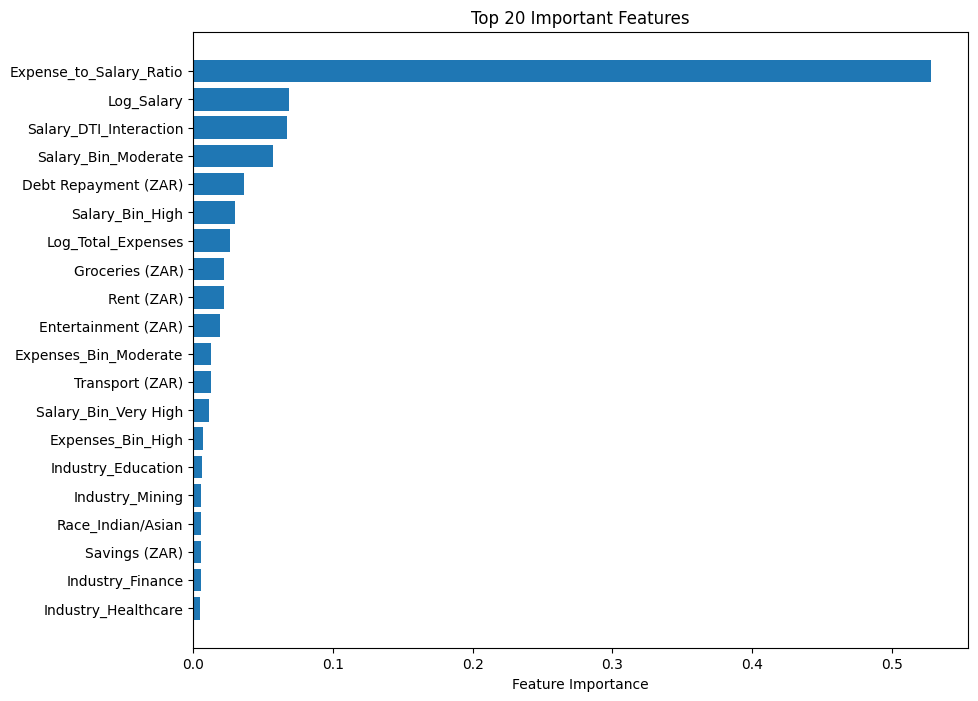

In [20]:
# feature importances
importances = xgb_clf.feature_importances_
feature_names = X_encoded.columns
indices = np.argsort(importances)[-20:]  # Top 20 features

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.show()